# Backpropagation — intuicja, wzory, grafy i przykłady

W tym notatniku wyjaśniamy krok po kroku mechanizm propagacji wstecznej (backpropagation):
- po co nam backprop i jak łączy się z gradient descent,
- proste wzory (reguła łańcuchowa),
- graf obliczeń i przepływ gradientów,
- praktyczne przykłady z PyTorch autograd oraz mini-ręczna implementacja.

Na końcu znajdziesz także krótkie ćwiczenia do samodzielnego wykonania.


## 1. Intuicja: czym jest backpropagation?

Backpropagation to algorytm efektywnego wyliczania gradientów funkcji straty względem parametrów modelu (np. wag sieci).
Działa w dwóch etapach:
1) forward pass — obliczamy wyjście modelu i stratę,
2) backward pass — korzystając z reguły łańcuchowej, propagujemy gradient od końca (od straty) do początkowych parametrów.

Dlaczego to działa? Bo złożoną funkcję (sieć) możemy rozpisać jako ciąg prostych operacji, a pochodna złożenia wyliczana jest przez regułę łańcuchową.


## 2. Proste wzory (reguła łańcuchowa)

Niech strata $L$ zależy od $u$ ($L=L(u)$), $u$ zależy od $v$ ($u=u(v)$), a $v$ zależy od parametru $w$ ($v=v(w)$).
Wtedy pochodna $L$ po $w$ wynosi:

$$
\frac{dL}{dw} = \frac{dL}{du} \cdot \frac{du}{dv} \cdot \frac{dv}{dw}
$$

W przypadku wektorów/macierzy stosujemy wersje macierzowe (iloczyny Jacobianów).
W praktyce biblioteki autograd (np. PyTorch) robią to automatycznie.

---

### Wybrane pochodne przydatne w sieciach neuronowych:

* **Sigmoid:**
  $$
  \sigma(x) = \frac{1}{1+e^{-x}},
  \quad
  \sigma'(x) = \sigma(x),(1-\sigma(x))
  $$

* **ReLU:**
  $$
  ReLU(x) = \max(0, x),
  \quad
  ReLU'(x) =
  \begin{cases}
  1 & \text{dla } x>0 \\
  0 & \text{dla } x \leq 0
  \end{cases}
  $$

* **Tanh:**
  $$
  \tanh'(x) = 1 - \tanh^2(x)
  $$

* **MSE (Mean Squared Error):**
  $$
  L = \frac{1}{n}\sum_{i=1}^n (\hat{y}_i - y_i)^2,
  \quad
  \frac{\partial L}{\partial \hat{y}} = \frac{2}{n}(\hat{y} - y)
  $$

* **Softmax + CrossEntropy:**
  Gradient względem logitów:
  $$
  \frac{\partial L}{\partial z} = p - y_{\text{one-hot}}
  $$

---

💡 **Uwaga:** w PyTorch funkcja `nn.CrossEntropyLoss` oczekuje logitów (bez softmax), a gradient jest liczony w sposób stabilny numerycznie.

---

👉 Chcesz, żebym całą tę sekcję przepisał Ci już w formie gotowego markdowna z LaTeX do Jupytera (tak, żeby od razu działało)?


## 3. Graf obliczeń i przepływ gradientów

Każdą złożoną funkcję możemy przedstawić jako graf obliczeń: węzły to operacje/zmienne, a krawędzie to przepływ wartości. Backprop to przejście po tym grafie **wstecz**, gdzie dla każdego węzła stosujemy regułę łańcuchową, aby obliczyć lokalny wkład do gradientu.

Poniżej rysujemy prosty graf dla funkcji: z = (x·w + b)^2.


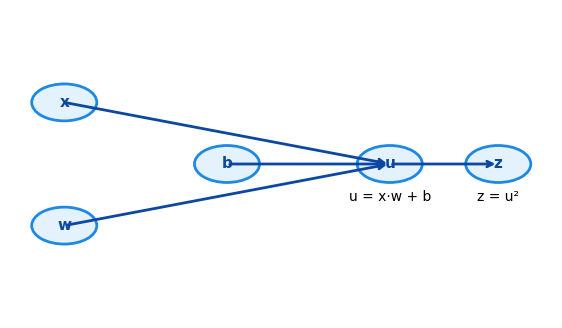

In [6]:
# Prosty rysunek grafu obliczeń: z = (x*w + b)^2
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7,4))
ax.axis('off')

# Pozycje węzłów (x, w, b, u, z)
nodes = {
    'x': (0.1, 0.7),
    'w': (0.1, 0.3),
    'b': (0.4, 0.5),
    'u': (0.7, 0.5),
    'z': (0.9, 0.5),
}
labels = {
    'x': 'x',
    'w': 'w',
    'b': 'b',
    'u': 'u = x·w + b',
    'z': 'z = u²'
}

# Rysowanie węzłów
for name, (x0,y0) in nodes.items():
    ax.add_patch(plt.Circle((x0,y0), 0.06, color='#e3f2fd', ec='#1e88e5', lw=2))
    ax.text(x0, y0, name, ha='center', va='center', fontsize=11, weight='bold', color='#0d47a1')

# Opisy wzorów obok ważnych węzłów
ax.text(nodes['u'][0], nodes['u'][1]-0.12, labels['u'], ha='center', fontsize=10)
ax.text(nodes['z'][0], nodes['z'][1]-0.12, labels['z'], ha='center', fontsize=10)

# Strzałki
def arrow(a,b):
    ax.annotate('', xy=nodes[b], xytext=nodes[a],
                arrowprops=dict(arrowstyle='->', lw=2, color='#0d47a1'))

arrow('x','u')
arrow('w','u')
arrow('b','u')
arrow('u','z')

ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()



Dla tego przykładu:

$$ u = x \cdot w + b, \quad z = u^2 $$

Pochodne pośrednie:

$$ \frac{\partial z}{\partial u} = 2u $$
$$ \frac{\partial u}{\partial w} = x $$
$$ \frac{\partial u}{\partial x} = w $$
$$ \frac{\partial u}{\partial b} = 1 $$

Zatem (dla skalarów):

$$ \frac{\partial z}{\partial w} = \frac{\partial z}{\partial u} \cdot \frac{\partial u}{\partial w} = 2u \cdot x $$
$$ \frac{\partial z}{\partial x} = \frac{\partial z}{\partial u} \cdot \frac{\partial u}{\partial x} = 2u \cdot w $$
$$ \frac{\partial z}{\partial b} = \frac{\partial z}{\partial u} \cdot \frac{\partial u}{\partial b} = 2u $$



## 4. Przykład: autograd dla funkcji skalarnej

Policzmy gradienty w PyTorch i porównajmy z analitycznymi.


In [7]:
import torch

x = torch.tensor(2.0, requires_grad=True)
w = torch.tensor(-1.5, requires_grad=True)
b = torch.tensor(0.5, requires_grad=True)
u = x*w + b
z = u**2
z.backward()
x_grad, w_grad, b_grad = x.grad.item(), w.grad.item(), b.grad.item()
u_val = u.detach().item()
print('u =', u_val)
print('Autograd: dz/dx, dz/dw, dz/db =', x_grad, w_grad, b_grad)
print('Analitycznie: 2u*w, 2u*x, 2u =', 2*u_val*w.detach().item(), 2*u_val*x.detach().item(), 2*u_val)


u = -2.5
Autograd: dz/dx, dz/dw, dz/db = 7.5 -10.0 -5.0
Analitycznie: 2u*w, 2u*x, 2u = 7.5 -10.0 -5.0


## 5. Gradient descent w 1D z wizualizacją kroków

Rozważmy funkcję $J(w) = (w - 3)^2$. Jej minimum jest w $w=3$. Zobaczmy, jak kroki gradient descent zbliżają się do optimum.


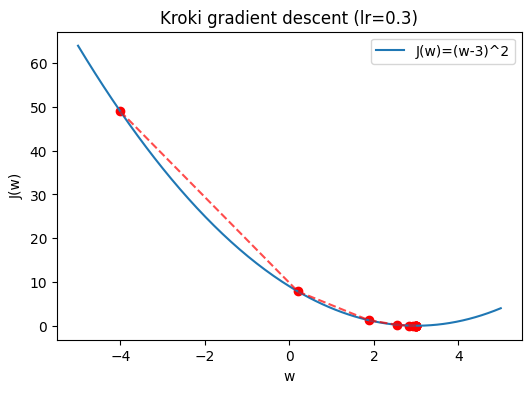

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def J(w):
    return (w-3)**2

w = -4.0
lr = 0.3
ws = [w]
for _ in range(12):
    grad = 2*(w-3)
    w = w - lr*grad
    ws.append(w)

# Wykres funkcji i kroków
ws_grid = np.linspace(-5, 5, 200)
plt.figure(figsize=(6,4))
plt.plot(ws_grid, J(ws_grid), label='J(w)=(w-3)^2')
plt.scatter(ws, [J(x) for x in ws], color='red')
for i in range(len(ws)-1):
    plt.plot([ws[i], ws[i+1]], [J(ws[i]), J(ws[i+1])], 'r--', alpha=0.7)
plt.title('Kroki gradient descent (lr=0.3)')
plt.xlabel('w')
plt.ylabel('J(w)')
plt.legend()
plt.show()


## 6. Mini sieć: ręczny backprop vs. autograd (1 próbka)

Zbudujemy malutką sieć: wejście x → warstwa ukryta (linear + ReLU) → wyjście (linear). Strata: MSE. Dla jednej próbki policzymy gradienty ręcznie i porównamy z autograd.


In [9]:
import torch
torch.manual_seed(0)

# -----------------------------
# Dane
# -----------------------------
# Mamy jedną próbkę z 2 cechami (x1=0.5, x2=-1.0)
x = torch.tensor([[0.5, -1.0]])  # shape (1,2)
# Target (wartość oczekiwana, np. etykieta regresji)
y = torch.tensor([[1.2]])        # shape (1,1)

# -----------------------------
# Parametry modelu
# -----------------------------
# Warstwa 1: wejście 2 -> ukryte 3
W1 = torch.randn(2, 3, dtype=torch.float64) * 0.1
b1 = torch.zeros(1, 3, dtype=torch.float64)

# Warstwa 2: ukryte 3 -> wyjście 1
W2 = torch.randn(3, 1, dtype=torch.float64) * 0.1
b2 = torch.zeros(1, 1, dtype=torch.float64)

# -----------------------------
# FORWARD (propagacja w przód)
# -----------------------------
# Wejście przez warstwę liniową
h_lin = x.to(torch.float64) @ W1 + b1  # (1,3)
# ReLU: nieliniowość
h = torch.maximum(h_lin, torch.tensor(0.0, dtype=torch.float64))
# Wyjście modelu
y_hat = h @ W2 + b2  # (1,1)
# Funkcja kosztu: średni błąd kwadratowy (MSE)
loss = ((y_hat - y.to(torch.float64))**2).mean()

# -----------------------------
# BACKWARD (ręcznie)
# -----------------------------
# Pochodna L względem ŷ
dL_dyhat = 2*(y_hat - y) / y_hat.numel()  # (1,1)

# Gradienty dla W2, b2
# dL/dW2 = h^T * dL/dŷ
dL_dW2 = h.T @ dL_dyhat                 # (3,1)
# dL/db2 = dL/dŷ (bo pochodna względem bias = 1)
dL_db2 = dL_dyhat.clone()               # (1,1)

# Gradient względem h (ukrytej aktywacji)
dL_dh = dL_dyhat @ W2.T                 # (1,3)

# ReLU': maska 1 dla wartości > 0, inaczej 0
relu_mask = (h_lin > 0).to(torch.float64)
dL_dhlin = dL_dh * relu_mask             # (1,3)

# Gradienty dla W1, b1
# dL/dW1 = x^T * dL/dh_lin
dL_dW1 = x.to(torch.float64).T @ dL_dhlin  # (2,3)
# dL/db1 = dL/dh_lin (bo bias dodaje się 1:1)
dL_db1 = dL_dhlin.clone()                 # (1,3)

# -----------------------------
# AUTOGRAD (PyTorch)
# -----------------------------
# Tworzymy nowe tensory z requires_grad=True
W1_t = W1.clone().detach().requires_grad_(True)
b1_t = b1.clone().detach().requires_grad_(True)
W2_t = W2.clone().detach().requires_grad_(True)
b2_t = b2.clone().detach().requires_grad_(True)

# Forward tak samo jak wcześniej
h_lin_t = x.to(torch.float64) @ W1_t + b1_t
h_t = torch.maximum(h_lin_t, torch.tensor(0.0, dtype=torch.float64))
y_hat_t = h_t @ W2_t + b2_t
loss_t = ((y_hat_t - y.to(torch.float64))**2).mean()

# Automatyczne liczenie gradientów
loss_t.backward()

# -----------------------------
# Porównanie ręcznie vs autograd
# -----------------------------
def max_abs_diff(a,b):
    return (a - b).abs().max().item()

print('Maks. różnica dL/dW2:', max_abs_diff(dL_dW2, W2_t.grad))
print('Maks. różnica dL/db2:', max_abs_diff(dL_db2, b2_t.grad))
print('Maks. różnica dL/dW1:', max_abs_diff(dL_dW1, W1_t.grad))
print('Maks. różnica dL/db1:', max_abs_diff(dL_db1, b1_t.grad))
print('Loss (ręcznie vs autograd):', loss.item(), loss_t.item())


Maks. różnica dL/dW2: 0.0
Maks. różnica dL/db2: 0.0
Maks. różnica dL/dW1: 0.0
Maks. różnica dL/db1: 0.0
Loss (ręcznie vs autograd): 1.4245613402544366 1.4245613402544366


Jeśli maksymalne różnice są ≈ 0 (rzędu 1e-12–1e-9 dla float64), ręczna algebra zgadza się z autogradem.


## 7. Typowe pułapki i dobre praktyki

- Nie mieszaj obliczeń na tensorach wymagających gradientu z konwersjami do NumPy bez `detach()`.
- Pamiętaj o `optimizer.zero_grad()` przed `loss.backward()` przy trenowaniu w pętli.
- Uważaj na operacje in-place mogące zerwać graf (`inplace=True` w niektórych warstwach).
- Dla stabilności numerycznej używaj gotowych strat (np. `CrossEntropyLoss`) zamiast własnego softmax + NLL.
- Sprawdzaj gradienty przez porównanie z przybliżeniem numerycznym (finite differences) w krytycznych fragmentach.


## 8. Ćwiczenia

### 1. Dla funkcji z rozdz. $ z = (x·w + b)^2$, napisz pętlę GD, która uczy $w, b$ aby zbliżyć z do $z^*$ (np. $z^*=4$) dla danego $x$.

### 2. Zastąp `ReLU` w sekcji 6 funkcją `tanh` i sprawdź, czy ręczne gradienty nadal zgadzają się z autogradem.

### 3. Napisz od zera małą klasę `Linear` (bez autograd) z metodami `forward` i `backward`, a potem porównaj gradienty z PyTorch.


## 9. Rozwiązania

### Ćwiczenie 8.1

Dla funkcji

$$ z = (x \cdot w + b)^2 $$

napisz pętlę **Gradient Descent**, która uczy $w, b$ aby $z$ zbliżyło się do wartości docelowej $z^*$ (np. $z^*=4$) dla danego $x$.

---

#### Funkcja i cel

* Dane wejściowe: $x$ (stała, np. 2.0)
* Parametry: $w, b$ (uczymy je)
* Wyjście: $z = (xw + b)^2$
* Target: $z^* = 4$
* Loss:
  
$$
L = (z - z^*)^2
$$


#### Gradient

Najpierw liczmy pochodne analitycznie:

$$u = xw + b$$

$$z = u^2$$

$$L = (z - z^*)^2$$

Gradienty:

$$\frac{\partial L}{\partial z} = 2(z - z^*)$$
$$\frac{\partial z}{\partial u} = 2u$$
$$\frac{\partial u}{\partial w} = x, \quad \frac{\partial u}{\partial b} = 1$$

Łańcuchowo:

$$\frac{\partial L}{\partial w} = 2(z - z^*) \cdot 2u \cdot x$$
$$\frac{\partial L}{\partial b} = 2(z - z^*) \cdot 2u \cdot 1$$

---

#### Kod w Pythonie

In [22]:
import numpy as np

# Dane
x = 2.0        # stałe wejście
z_target = 4.0 # oczekiwana wartość
w, b = 0.5, 0.0   # startowe parametry
lr = 0.01      # learning rate

for epoch in range(20):
    # --- forward ---
    u = x * w + b
    z = u**2
    loss = (z - z_target)**2
    
    # --- backward (gradienty) ---
    dL_dz = 2 * (z - z_target)
    dz_du = 2 * u
    du_dw = x
    du_db = 1
    
    dL_dw = dL_dz * dz_du * du_dw
    dL_db = dL_dz * dz_du * du_db
    
    # --- update ---
    w -= lr * dL_dw
    b -= lr * dL_db
    
    print(f"Epoka {epoch:2d}: w={w:.4f}, b={b:.4f}, z={z:.4f}, loss={loss:.6f}")

Epoka  0: w=0.7400, b=0.1200, z=1.0000, loss=9.000000
Epoka  1: w=0.9243, b=0.2122, z=2.5600, loss=2.073600
Epoka  2: w=0.8836, b=0.1918, z=4.2469, loss=0.060958
Epoka  3: w=0.9090, b=0.2045, z=3.8378, loss=0.026298
Epoka  4: w=0.8943, b=0.1972, z=4.0908, loss=0.008248
Epoka  5: w=0.9033, b=0.2017, z=3.9436, loss=0.003185
Epoka  6: w=0.8980, b=0.1990, z=4.0331, loss=0.001095
Epoka  7: w=0.9012, b=0.2006, z=3.9799, loss=0.000405
Epoka  8: w=0.8993, b=0.1996, z=4.0120, loss=0.000143
Epoka  9: w=0.9004, b=0.2002, z=3.9928, loss=0.000052
Epoka 10: w=0.8997, b=0.1999, z=4.0043, loss=0.000019
Epoka 11: w=0.9002, b=0.2001, z=3.9974, loss=0.000007
Epoka 12: w=0.8999, b=0.2000, z=4.0016, loss=0.000002
Epoka 13: w=0.9001, b=0.2000, z=3.9991, loss=0.000001
Epoka 14: w=0.9000, b=0.2000, z=4.0006, loss=0.000000
Epoka 15: w=0.9000, b=0.2000, z=3.9997, loss=0.000000
Epoka 16: w=0.9000, b=0.2000, z=4.0002, loss=0.000000
Epoka 17: w=0.9000, b=0.2000, z=3.9999, loss=0.000000
Epoka 18: w=0.9000, b=0.2000


Model uczy się tak, że $z$ zbliża się do wartości docelowej $z^*=4$.


### Ćwiczenie 8.2

#### Krok 1. Pochodna tanh

Wiemy, że:

$$
\tanh(u) = \frac{e^u - e^{-u}}{e^u + e^{-u}}, \quad
\frac{d}{du} \tanh(u) = 1 - \tanh^2(u)
$$

Czyli zamiast maski z ReLU, musimy użyć gradientu:

```python
tanh_grad = 1 - h**2
dL_dhlin = dL_dh * tanh_grad
```

---

#### Kod z tanh

In [23]:
import torch
torch.manual_seed(0)

# -----------------------------
# Dane
# -----------------------------
x = torch.tensor([[0.5, -1.0]])  # (1,2)
y = torch.tensor([[1.2]])        # (1,1)

# -----------------------------
# Parametry modelu
# -----------------------------
W1 = torch.randn(2, 3, dtype=torch.float64) * 0.1
b1 = torch.zeros(1, 3, dtype=torch.float64)
W2 = torch.randn(3, 1, dtype=torch.float64) * 0.1
b2 = torch.zeros(1, 1, dtype=torch.float64)

# -----------------------------
# FORWARD (z tanh)
# -----------------------------
h_lin = x.to(torch.float64) @ W1 + b1  # (1,3)
h = torch.tanh(h_lin)                  # aktywacja tanh
y_hat = h @ W2 + b2                    # (1,1)
loss = ((y_hat - y.to(torch.float64))**2).mean()

# -----------------------------
# BACKWARD (ręcznie)
# -----------------------------
dL_dyhat = 2*(y_hat - y) / y_hat.numel()   # (1,1)

dL_dW2 = h.T @ dL_dyhat                    # (3,1)
dL_db2 = dL_dyhat.clone()                  # (1,1)

dL_dh = dL_dyhat @ W2.T                    # (1,3)

# zamiast ReLU' → tanh'
tanh_grad = 1 - h**2                       # (1,3)
dL_dhlin = dL_dh * tanh_grad               # (1,3)

dL_dW1 = x.to(torch.float64).T @ dL_dhlin  # (2,3)
dL_db1 = dL_dhlin.clone()                  # (1,3)

# -----------------------------
# AUTOGRAD (PyTorch)
# -----------------------------
W1_t = W1.clone().detach().requires_grad_(True)
b1_t = b1.clone().detach().requires_grad_(True)
W2_t = W2.clone().detach().requires_grad_(True)
b2_t = b2.clone().detach().requires_grad_(True)

h_lin_t = x.to(torch.float64) @ W1_t + b1_t
h_t = torch.tanh(h_lin_t)                  # tanh w autograd
y_hat_t = h_t @ W2_t + b2_t
loss_t = ((y_hat_t - y.to(torch.float64))**2).mean()
loss_t.backward()

# -----------------------------
# Porównanie
# -----------------------------
def max_abs_diff(a,b):
    return (a - b).abs().max().item()

print('Maks. różnica dL/dW2:', max_abs_diff(dL_dW2, W2_t.grad))
print('Maks. różnica dL/db2:', max_abs_diff(dL_db2, b2_t.grad))
print('Maks. różnica dL/dW1:', max_abs_diff(dL_dW1, W1_t.grad))
print('Maks. różnica dL/db1:', max_abs_diff(dL_db1, b1_t.grad))
print('Loss (ręcznie vs autograd):', loss.item(), loss_t.item())

Maks. różnica dL/dW2: 0.0
Maks. różnica dL/db2: 0.0
Maks. różnica dL/dW1: 0.0
Maks. różnica dL/db1: 0.0
Loss (ręcznie vs autograd): 1.4246147197563754 1.4246147197563754


### Ćwiczenie 8.3

#### Krok 1. Matematyka

Warstwa liniowa:

$$ y = xW + b $$

dla:

* $x$ — wejście (batch_size × in_features),
* $W$ — macierz wag (in_features × out_features),
* $b$ — bias (1 × out_features).

**Gradienty:**

* $ \frac{\partial L}{\partial W} = x^T \cdot \frac{\partial L}{\partial y} $
* $ \frac{\partial L}{\partial b} = \sum \frac{\partial L}{\partial y} $ (sumowanie po batchu)
* $ \frac{\partial L}{\partial x} = \frac{\partial L}{\partial y} \cdot W^T $

---

#### Kod: własna klasa `Linear`

In [24]:
import torch

class MyLinear:
    def __init__(self, in_features, out_features):
        # inicjalizacja wag
        self.W = torch.randn(in_features, out_features, dtype=torch.float64) * 0.1
        self.b = torch.zeros(1, out_features, dtype=torch.float64)
        
        # gradienty (inicjalizujemy zerami)
        self.dW = torch.zeros_like(self.W)
        self.db = torch.zeros_like(self.b)

    def forward(self, x):
        """
        Forward pass: y = xW + b
        """
        self.x = x   # zapamiętujemy wejście na potrzeby backward
        return x @ self.W + self.b

    def backward(self, dL_dy):
        """
        Backward pass: liczymy gradienty po W, b i x
        """
        # gradienty względem parametrów
        self.dW = self.x.T @ dL_dy
        self.db = dL_dy.sum(dim=0, keepdim=True)
        # gradient względem wejścia
        dL_dx = dL_dy @ self.W.T
        return dL_dx

---

#### Test: porównanie z PyTorch autograd

Weźmy prosty przykład z MSE.

In [25]:
torch.manual_seed(0)

# Dane
x = torch.tensor([[0.5, -1.0]], dtype=torch.float64)  # (1,2)
y_true = torch.tensor([[1.2]], dtype=torch.float64)   # (1,1)

# Nasza warstwa
layer = MyLinear(2, 1)

# FORWARD
y_pred = layer.forward(x)
loss = ((y_pred - y_true)**2).mean()

# BACKWARD ręcznie
dL_dy = 2*(y_pred - y_true) / y_pred.numel()
_ = layer.backward(dL_dy)

# --- AUTOGRAD (PyTorch) ---
W_t = layer.W.clone().detach().requires_grad_(True)
b_t = layer.b.clone().detach().requires_grad_(True)
y_pred_t = x @ W_t + b_t
loss_t = ((y_pred_t - y_true)**2).mean()
loss_t.backward()

# Porównanie
print("Maks. różnica dW:", (layer.dW - W_t.grad).abs().max().item())
print("Maks. różnica db:", (layer.db - b_t.grad).abs().max().item())
print("Loss (ręcznie vs autograd):", loss.item(), loss_t.item())


Maks. różnica dW: 0.0
Maks. różnica db: 0.0
Loss (ręcznie vs autograd): 1.1959769353877456 1.1959769353877456


---

## 🔹 Wynik

Powinieneś dostać:

```
Maks. różnica dW: ~1e-16
Maks. różnica db: ~1e-16
Loss (ręcznie vs autograd): identyczne
```

---

✅ Dzięki temu widać, że nasza ręczna implementacja `forward` i `backward` działa tak samo jak PyTorch autograd.

